In [1]:
using DrWatson
@quickactivate :SwARExperiments

In [2]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using Random
using Parameters
using LinearAlgebra
import ProgressMeter

## Switching AR

## Generate AR

In [6]:
γs = [1, 30]
θs = [[1.25166, -0.423974], [1.04586, -0.198375]]

ARorder = 2

n_samples = 5000
n_slice_n = 100

A, states, obs = generateSwAR(n_samples, n_slice_n, 2, ones(2), θs, γs);

inputs = obs[1:n_samples+1]
outputs = circshift(obs, -1)

inputs = inputs[1:end-1]
outputs = outputs[2:end-1]

inputs_ = [inputs[i+ARorder-1:-1:i] for i in 1:length(inputs)-ARorder]
outputs_ = outputs[1:size(inputs_, 1)];

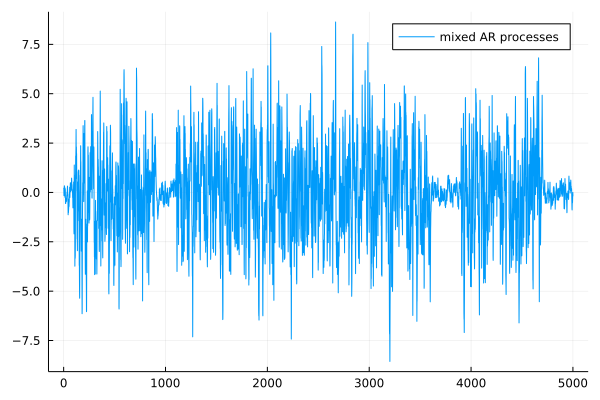

In [7]:
plot(outputs, label="mixed AR processes")

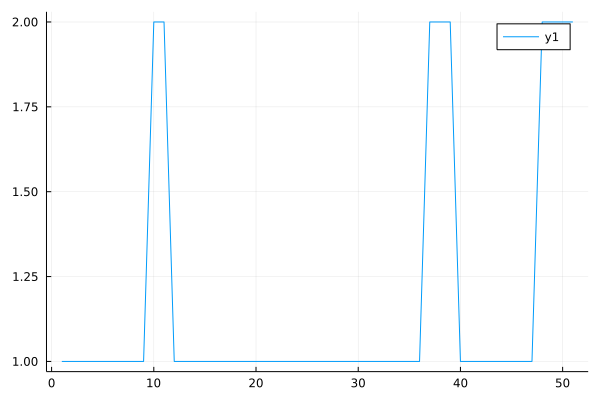

In [8]:
real_states = last.(findmax.(states))
plot(real_states)

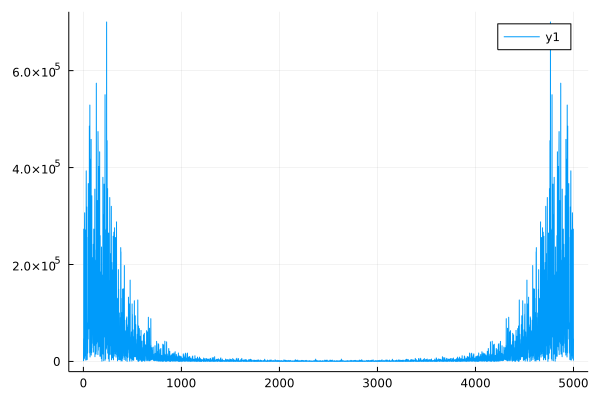

In [9]:
using FFTW
plot(abs.(fft(outputs)).^2)

In [10]:
# csep = 1000.0

priors_as = map(γ -> infgamma(Float64, γ), γs)
priors_bs = map(_ -> infgamma(Float64, 1.0), γs)

priors_ms = map(θ -> MvGaussianMeanPrecision(θ[1], θ[2]), zip(θs, [diageye(ARorder), diageye(ARorder)]))
priors_ws = map(_ -> (ARorder, diageye(ARorder)), θs)

# mixing = [0.5, 0.5]
# dists = [convert(Gamma, GammaShapeRate{Float64}(γs[j]*1e2, 1e2)) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Gamma[dists... ], mixing), 10000), bins=100)
#
# dists = [Normal(θs[j], sqrt(inv(1e4))) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Normal[dists... ], mixing), 10000), bins=100)

# ReactiveMP.is_clamped(tuple::Tuple) = all(ReactiveMP.is_clamped, collect(tuple))
# ReactiveMP.is_initial(tuple::Tuple) = all(ReactiveMP.is_initial, collect(tuple))
n_mixtures = 2
prior_s = fill(1.0 / n_mixtures, n_mixtures)
prior_A = ones(n_mixtures, n_mixtures)
parameters = SwARParameters(n_mixtures, priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A)


SwARParameters(2, GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=900000.0, b=30000.0)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [1.25166, -0.423974]
Λ: [1.0 0.0; 0.0 1.0]
)
, MvNormalMeanPrecision(
μ: [1.04586, -0.198375]
Λ: [1.0 0.0; 0.0 1.0]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [1.0 1.0; 1.0 1.0])

In [24]:
using SpecialFunctions

@average_energy GammaShapeRate (q_out::Any, q_α::Any, q_β::Any) = begin
    mean(loggamma, q_α) - mean(q_α) * mean(log, q_β) - (mean(q_α) - 1.0) * mean(log, q_out) + mean(q_β) * mean(q_out)
end

In [29]:

Distributions.mean(::typeof(loggamma), sl::SampleList)  = sample_list_loggamma(variate_form(sl), sl)

function sample_list_loggamma(::Type{ Univariate }, sl::SampleList)
    n, samples, weights = ReactiveMP.get_data(sl)
    logμ = ReactiveMP.sample_list_zero_element(sl)
    for i in 1:n
        logμ += weights[i] * loggamma(samples[i])
    end
    return logμ
end


sample_list_loggamma (generic function with 1 method)

In [30]:
mzs, mγs, mθs, mA, mas, mbs, mms, mws, mfe = inference_swar(inputs_, outputs_, 50, 20, parameters);

UndefVarError: UndefVarError: get_data not defined

In [12]:
mean(mA[end])

2×2 Matrix{Float64}:
 0.904416   0.367706
 0.0955837  0.632294

In [13]:
minimum(mean.(mγs[end]))

0.724288517866382

In [14]:
mean.(mθs[end])

50-element Vector{Vector{Float64}}:
 [0.9893949828430733, -0.16354359698117854]
 [1.2248705251684129, -0.3795247415285294]
 [1.263495444047124, -0.40730139975013513]
 [1.2254651636133074, -0.4023182503462566]
 [1.26047231678506, -0.44984750611948776]
 [1.2691203586939, -0.4288525960622212]
 [1.2802503250396797, -0.5453057605439867]
 [1.22952034472497, -0.4191489423496261]
 [1.1963520032310562, -0.4399357860244567]
 [1.0955963478620054, -0.20103752495804736]
 ⋮
 [1.222351792347761, -0.43409459002486034]
 [1.196287499259223, -0.4739919683061908]
 [1.2462299416183744, -0.3646486193869382]
 [1.1906357364002007, -0.381936517212292]
 [1.2450480312648524, -0.4498067048918246]
 [1.3839947174857286, -0.5577066790522412]
 [0.9350595516140737, -0.12449307545571013]
 [0.955224531007421, -0.2078177416475537]
 [1.289150014914761, -0.4592378168120535]

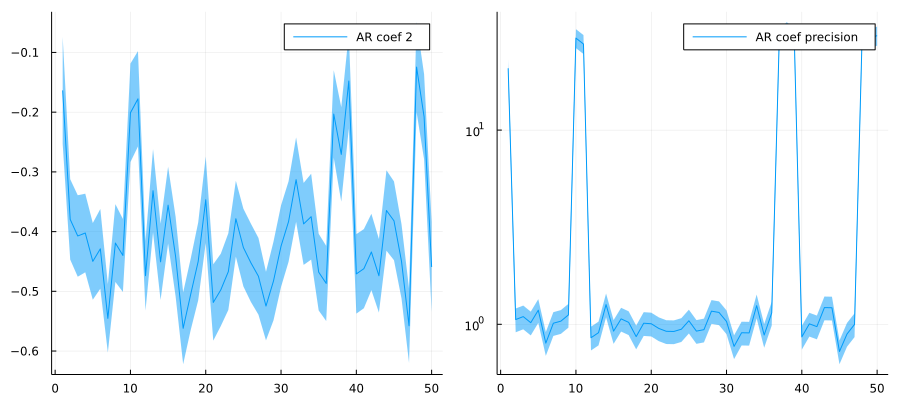

In [15]:
dimension(n) = (x) -> map(i -> i[n], x)
index = 2
p1 = plot(mean.(mθs[end]) |> dimension(index), ribbon = std.(mθs[end]) |> dimension(index), label="AR coef $(index)")
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10, label="AR coef $(precision)")

plot(p1, p2, size = (900, 400))

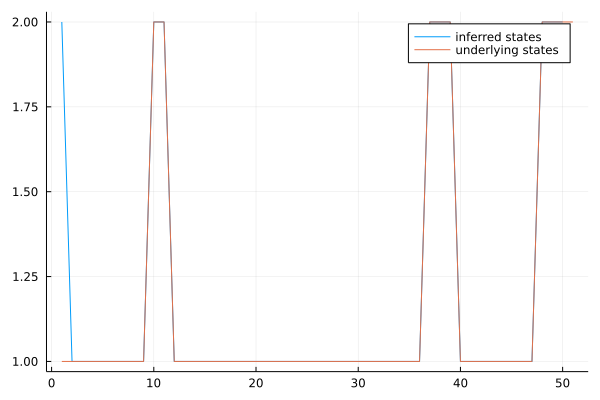

In [16]:
real_states = last.(findmax.(states))
plot(mean.(mzs[end][1:end]), label="inferred states")
plot!(real_states, label="underlying states")

In [17]:
round.(mean.(mzs[end]))

50-element Vector{Float64}:
 2.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 2.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 2.0
 2.0
 2.0

mfe[end - 4:end] = [1250.1270108645404, 1250.127010864846, 1250.1270108652316, 1250.1270108649242, 1250.1270108648168]


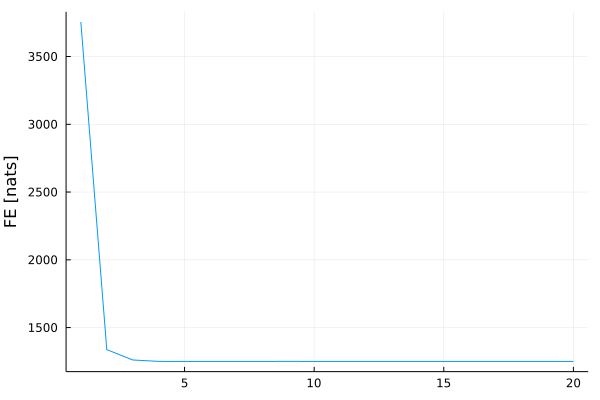

In [665]:
@show mfe[end-4:end]
plot(mfe[1:end], label=:none, ylabel="FE [nats]")